In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

### Ingest/Clean
***

We'll make sure to exclude columns that aren't useful for analysis and fill NaN's with mode/median depending on column type. In a more strenuous analysis we'd impute missing values and check for outliers.

In [15]:
# Define cleaning function to apply to both testing and training data
def clean_data(df, set = None):
       
       # Drop row if outcome is NaN, can't train on these
       if set == "train": df = df.dropna(subset=['Genetic Disorder', 'Disorder Subclass'], how='any')

       rhs = df.drop(['Patient Id', 'Patient First Name', 'Family Name', "Father's name",
              'Institute Name', 'Institute Name', 'Location of Institute', 'Status',
              'Genetic Disorder', 'Disorder Subclass'
              ], axis = 1, errors = 'ignore')
       
       # Fill NaN with mode for categorical columns, median for numeric columns
       for i in rhs.select_dtypes(include='object').columns:

              # Unfortunately, the data we chose has a test set deliberately corrupted with -99 values...
              rhs[i] = rhs[i].replace("-99", np.NaN)
              rhs[i] = rhs[i].fillna(rhs[i].mode().values[0])

              # Create dummies for categorical columns (one hot encoding)
              rhs = pd.concat([rhs, pd.get_dummies(rhs[i], drop_first=True, prefix=i)], axis = 1)
              rhs = rhs.drop(columns=i)

       for i in rhs.select_dtypes(include=['float64', 'int64']):

              # Unfortunately, the data we chose has a test set deliberately corrupted with -99 values...
              rhs[i] = rhs[i].replace(-99, np.NaN)
              rhs[i] = rhs[i].fillna(rhs[i].median())

       # Output is train/test dependant
       if set == "train":

              lhs = df[["Genetic Disorder", "Disorder Subclass"]]
       
              return lhs, rhs
       
       if set == "test": return rhs

       else: raise Exception("Please define sample as 'test' or 'train'.") 

In [16]:
labels, x = clean_data(pd.read_csv("../data/train.csv"), "train")
x.head(5)

,Patient Age,Blood cell count (mcL),Mother's age,Father's age,Test 1,Test 2,Test 3,Test 4,Test 5,No. of previous abortion,...,H/O radiation exposure (x-ray)_Yes,H/O substance abuse_No,H/O substance abuse_Not applicable,H/O substance abuse_Yes,Assisted conception IVF/ART_Yes,History of anomalies in previous pregnancies_Yes,Birth defects_Singular,Blood test result_inconclusive,Blood test result_normal,Blood test result_slightly abnormal
0,2.0,4.760603,35.0,42.0,0.0,0.0,0.0,1.0,0.0,2.0,...,0,1,0,0,0,1,0,0,0,1
2,6.0,4.893297,41.0,22.0,0.0,0.0,0.0,1.0,0.0,4.0,...,1,1,0,0,1,1,1,0,1,0
3,12.0,4.705280,21.0,42.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0,0,1,0,1,1,1,1,0,0
4,11.0,4.720703,32.0,42.0,0.0,0.0,0.0,1.0,0.0,4.0,...,0,0,1,0,1,0,0,0,0,1
5,14.0,5.103188,35.0,42.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0,1,0,0,1,0,0,0,1,0


In [17]:
len(labels)

18047

In [18]:
# Check to make sure we've recoded all NAs
x.isna().sum()

Patient Age                                                  0
Blood cell count (mcL)                                       0
Mother's age                                                 0
Father's age                                                 0
Test 1                                                       0
Test 2                                                       0
Test 3                                                       0
Test 4                                                       0
Test 5                                                       0
No. of previous abortion                                     0
White Blood cell count (thousand per microliter)             0
Symptom 1                                                    0
Symptom 2                                                    0
Symptom 3                                                    0
Symptom 4                                                    0
Symptom 5                                              

(array([9241.,    0.,    0.,    0.,    0., 1877.,    0.,    0.,    0.,
        6929.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

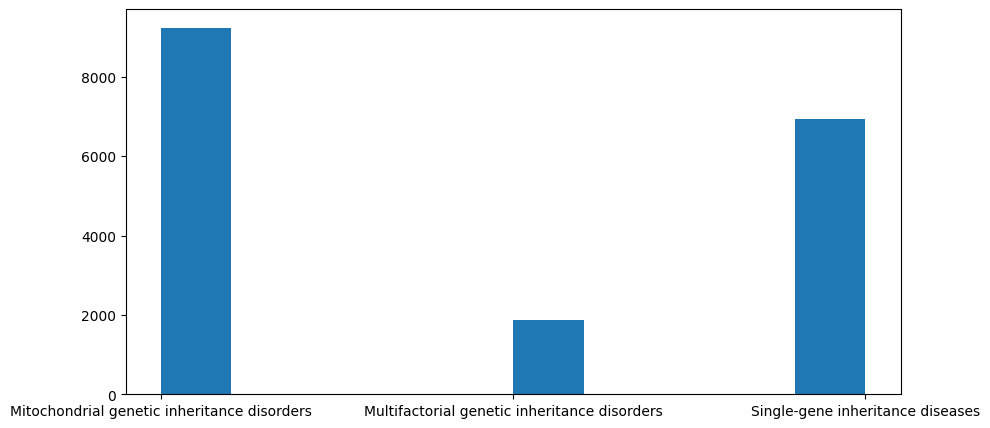

In [19]:
plt.figure(figsize=(10,5),dpi = 100)
plt.hist(labels['Genetic Disorder'])

(array([ 587., 1653., 4683.,   91.,    0., 3145., 2556., 1228., 3971.,
         133.]),
 array([0. , 0.8, 1.6, 2.4, 3.2, 4. , 4.8, 5.6, 6.4, 7.2, 8. ]),
 <BarContainer object of 10 artists>)

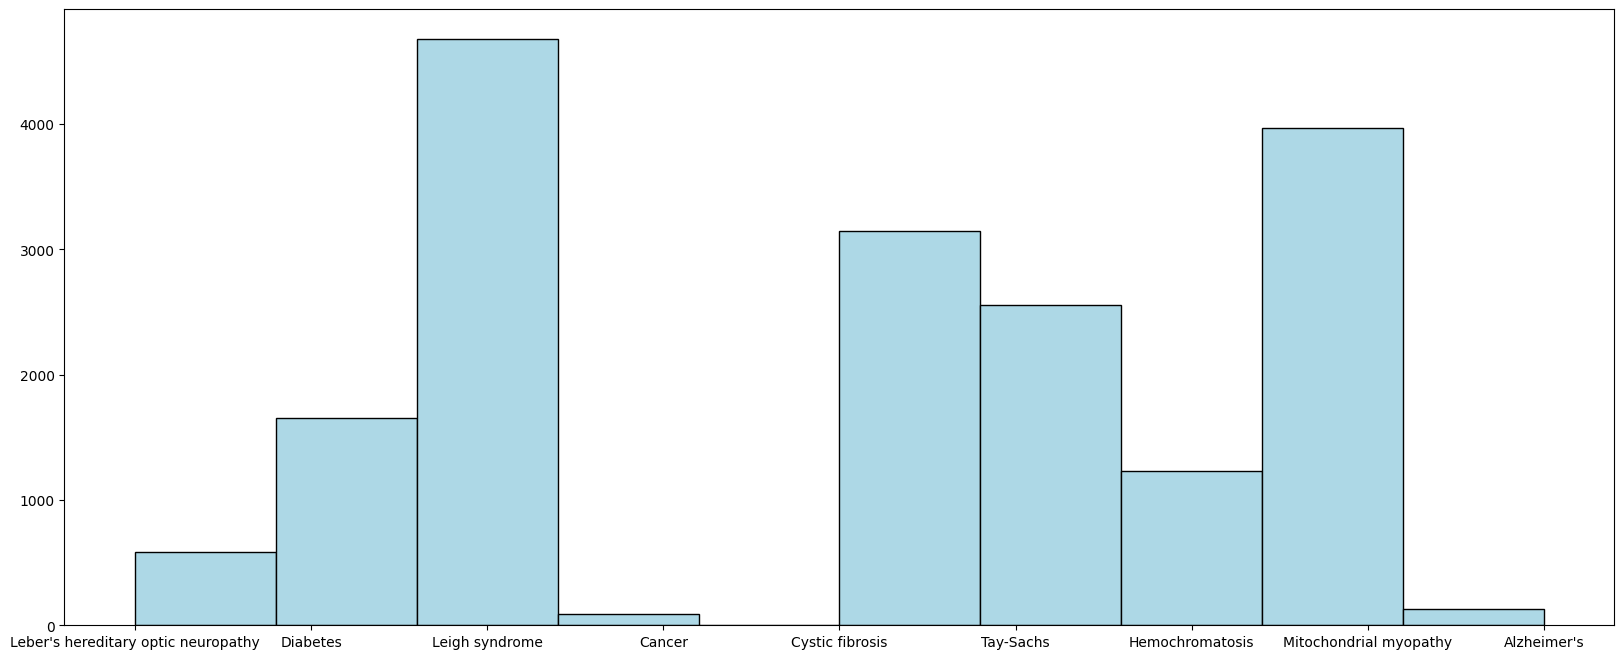

In [20]:
plt.figure(figsize=(20,8))
plt.hist(labels['Disorder Subclass'], color = "lightblue", ec="black")

### Splitting the Dataset
***
We originally wrote this script to work with the provided test set, but it doesn't include labels which makes it unusable for testing model performance.

In [21]:
y1 = labels['Genetic Disorder']
y2 = labels['Disorder Subclass']

x1_train, x1_test, y1_train, y1_test = train_test_split(x, y1, test_size=0.2)
x2_train, x2_test, y2_train, y2_test = train_test_split(x, y2, test_size=0.2)

### Train
***

We have a specific set of circumstances with this data that will dictate which types of modelling we should use:

1. A mix of categorical and numeric data
2. A categorical outcome we're trying to classify
3. And since we're trying to classify, our methods must be supervised

Surely there are a number of different methods we could test out here, but in the interest of time, let's go with a random forest since decision tree is paticularly suited to mixed data like this, and random forest is superior to a single tree.

In [22]:
clf1 = RandomForestClassifier(max_depth=9, random_state=0)
clf1.fit(x1_train, y1_train)

clf2 = RandomForestClassifier(max_depth=9, random_state=0)
clf2.fit(x2_train, y2_train)

RandomForestClassifier(max_depth=9, random_state=0)

In [23]:
clf1.score(x1_train, y1_train)

0.6836600401745515

In [24]:
clf2.score(x2_train, y2_train)

0.6094063863683591

### Test
***

In [25]:
clf1.score(x1_test, y1_test)

0.5515235457063712

In [26]:
clf2.score(x2_test, y2_test)

0.38365650969529086

### Conclusion
***
The model seems to do alright. It's definitely overfitted based on the worse performance for test than training, but lowering the tree depth didn't improve performance at all, so there must be some other paramaters we should play with. We could also look into gradient boosting models and Linear Support Vector Regression (though we'd have to normalize out inputs for this).